In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

from env import get_db_url
import wrangle as wgl
import split_scale as ss

url = get_db_url('telco_churn')
df = pd.read_sql('''
SELECT customer_id, tenure, monthly_charges, total_charges
FROM customers
where contract_type_id = 3
''', url)


In [2]:
df = wgl.wrangle_telco(df)
df = wgl.drop_nulls(df)
df.total_charges = df.total_charges.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 1694
Data columns (total 4 columns):
customer_id        1685 non-null object
tenure             1685 non-null int64
monthly_charges    1685 non-null float64
total_charges      1685 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 65.8+ KB


In [3]:
train, test = ss.split_my_data(df)

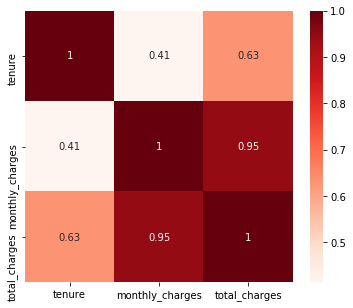

In [4]:
plt.figure(figsize=(6,5))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [5]:
#Correlation with output variable
cor_target = abs(cor["total_charges"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

tenure             0.630454
monthly_charges    0.945798
total_charges      1.000000
Name: total_charges, dtype: float64

In [6]:
x_train = train[['tenure', 'monthly_charges']]
y_train = train[['total_charges']]

### Our scenario continues:
#### As a customer analyst, I want to know who has spent the most money with us over their lifetime. I have monthly charges and tenure, so I think I will be able to use those two attributes as features to estimate total_charges. I need to do this within an average of $5.00 per customer.

1) Write a function, *select_kbest_chisquared()* that takes **X_train**, **y_train** and **k** as input ***(X_train and y_train should not be scaled!)*** and returns a list of the top k features.

In [7]:
from sklearn.feature_selection import SelectKBest, chi2
def select_kbest_chisquared(x, y, k = 2):
    f_selector = SelectKBest(chi2, k)
    
    f_selector.fit(x,y)
    
    f_support = f_selector.get_support()
    f_feature = x.loc[:,f_support].columns.tolist()
    return f_feature
    pass

2) Write a function, select_kbest_freg() that takes X_train, y_train (scaled) and k as input and returns a list of the top k features.


In [8]:
from sklearn.feature_selection import SelectKBest, f_regression
def select_kbest_freg(x, y, k = 2):
    f_selector = SelectKBest(f_regression, k)

    f_selector.fit(x,y)

    f_support = f_selector.get_support()
    f_feature = x.loc[:,f_support].columns.tolist()
    return f_feature

In [9]:
select_kbest_freg(x_train, y_train, 2)

['tenure', 'monthly_charges']

3) Write a function, ols_backware_elimination() that takes X_train and y_train (scaled) as input and returns selected features based on the ols backwards elimination method.

In [10]:
import statsmodels.api as sm
def ols_backward_elimination(x, y):
    cols = x.columns
    while (len(cols)>0):
        x_1 = x[cols]
        model = sm.OLS(y, x_1).fit()
        p = pd.Series(model.pvalues.values[0:],index = cols)
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
        else:
            break
    return cols

In [11]:
ols_backward_elimination(x_train, y_train)

Index(['tenure', 'monthly_charges'], dtype='object')

4) Write a function, lasso_cv_coef() that takes X_train and y_train as input and returns the coefficients for each feature, along with a plot of the features and their weights.

In [12]:
from sklearn.linear_model import LassoCV
def lasso_cv_coef(x, y):
    reg = LassoCV()
    reg.fit(x,y)
    
    coef = pd.Series(reg.coef_, index = x.columns)
    return coef

In [13]:
lasso_cv_coef(x_train, y_train)

tenure             42.273433
monthly_charges    61.130451
dtype: float64

5) Write 3 functions, the first computes the number of optimum features (n) using rfe, the second takes n as input and returns the top n features, and the third takes the list of the top n features as input and returns a new X_train and X_test dataframe with those top features , recursive_feature_elimination() that computes the optimum number of features (n) and returns the top n features.

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

def optimum_feature_count(x_train, y_train, x_test, y_test):
    number_of_features_list = np.arange(1,3)
    high_score = 0
    
    number_of_features = 0
    score_list = []
    
    for i in range(len(number_of_features_list)):
        model = LinearRegression()
        rfe = RFE(model, number_of_features_list[i])
        x_train_rfe = rfe.fit_transform(x_train, y_train)
        x_test_rfe  = rfe.transform(x_test)
        model.fit(x_train_rfe, y_train)
        score = model.score(x_test_rfe, y_test)
        score_list.append(score)
        if(score > high_score):
            high_score = score
            number_of_features = number_of_features_list[i]
    return number_of_features

In [15]:
x_test = test[['tenure', 'monthly_charges']]
y_test = test[['total_charges']]
count = optimum_feature_count(x_train, y_train, x_test, y_test)
count

2

In [16]:
def optimum_feature_names(x_train, y_train, feature_count):
    cols = list(x_train.columns)
    model = LinearRegression()
    
    rfe = RFE(model, feature_count)
    
    x_rfe = rfe.fit_transform(x_train, y_train)
    temp = pd.Series(rfe.support_, index = cols)
    selected_features_rfe = temp[temp==True].index
    
    return selected_features_rfe

In [17]:
features = list(optimum_feature_names(x_train, y_train, count))
features

['tenure', 'monthly_charges']

In [37]:
from split_scale import split_my_data
def optimum_data_sets(features, target, dataframe, train_pct = 0.8):
    cols = features + target
    split_my_data(dataframe[cols], train_pct = train_pct)
    
    
    pass

In [47]:
def recursive_feature_elimination(features, target, dataframe, train_pct = 0.8):
    cols = features+target
    train, test = split_my_data(dataframe[cols], train_pct = train_pct)
    n = optimum_feature_count(train[features], train[target], test[features], test[target])
    features = optimum_feature_names(train[features], train[target], n)
    train = train[features].join(train[target])
    test = test[features].join(test[target])
    return train, test, features

In [50]:
train, test, features = recursive_feature_elimination(['tenure', 'monthly_charges'], ['total_charges'], df)
features

Index(['tenure', 'monthly_charges'], dtype='object')